# Title: Classifying Explicit Songs on Spotify From 2010-2019 via K-Nearest Neighbors

In [1]:
install.packages("themis")
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(themis)
library(RColorBrewer)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune      0.1.1
✔ modeldata 0.0.2     ✔ workflows 0.2.0
✔ parsnip   0.1.

# 1. Introduction

### In this study, we will study a data set of Top Hit Spotify Songs from 2000-to 2019, originating from Kaggle. 
The data is organized into 18 columns, each of which describes the track and its quality. A detailed description of all the columns content can be found here: https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019".

We want to answer a predictive question: Can we use a song's traits to predict whether a song in 2010-2019 on Spotify is explicit or not? Answering this question is noteworthy because Spotify has an explicit content filter that allows users to filter out songs containing language that may be considered offensive to children. However, Spotify's explicit content tag is based on information provided by the rights holder; thus, not all tracks with explicit content are properly labelled, and users must manually report those they missed. Hence, this study set out to investigate an alternative solution to predict and thus label whether a song may be explicit or not. A rigorous answer to this question could help Spotify enhance its explicit content filter and improve user experience.


In [2]:
# read + clean + wrangle data ----------------------------------------------------
single_genre <- c('country', 'latin', 'Dance/Electronic', 'Folk/Acoustic',
'pop', 'rock','hip hop','R&B','metal','jazz','blues','classical','World/Traditional')

In [18]:
set.seed(999)
options(repr.plot.width = 8, repr.plot.height = 8)
song <- read_csv('https://raw.githubusercontent.com/nicolelassetter/DSCI100-project-g28/main/songs_normalize.csv') %>%
    mutate(genre <- as_factor(genre))%>%
    filter(genre %in% single_genre)
head(song) # small preview of data set

Parsed with column specification:
cols(
  artist = col_character(),
  song = col_character(),
  duration_ms = col_double(),
  explicit = col_logical(),
  year = col_double(),
  popularity = col_double(),
  danceability = col_double(),
  energy = col_double(),
  key = col_double(),
  loudness = col_double(),
  mode = col_double(),
  speechiness = col_double(),
  acousticness = col_double(),
  instrumentalness = col_double(),
  liveness = col_double(),
  valence = col_double(),
  tempo = col_double(),
  genre = col_character()
)



artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre <- as_factor(genre)
<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
Britney Spears,Oops!...I Did It Again,211160,FALSE,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.30000,1.77e-05,0.3550,0.894,95.053,pop,pop
*NSYNC,Bye Bye Bye,200560,FALSE,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.04080,1.04e-03,0.0845,0.879,172.656,pop,pop
Eminem,The Real Slim Shady,284200,TRUE,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.00e+00,0.0454,0.760,104.504,hip hop,hip hop
Modjo,Lady - Hear Me Tonight,307153,FALSE,2001,77,0.720,0.808,6,-5.627,1,0.0379,0.00793,2.93e-02,0.0634,0.869,126.041,Dance/Electronic,Dance/Electronic
Gigi D'Agostino,L'Amour Toujours,238759,FALSE,2011,1,0.617,0.728,7,-7.932,1,0.0292,0.03280,4.82e-02,0.3600,0.808,139.066,pop,pop
Eiffel 65,Move Your Body - Gabry Ponte Original Radio Edit,268863,FALSE,1999,56,0.745,0.958,7,-9.664,1,0.0287,0.08130,3.24e-01,0.5330,0.960,129.962,pop,pop


In [32]:
# count the row of missing data to see if we need to tidy our data, and the result is zero.
sum(anyNA(song))

# count how many explicit vs non-explict are present to see if we need to balance the data prior training to avoid bias,
# and the result is that this data is imbalance, and will need to be balanced prior training.
n_explicit <- song %>%
    group_by(explicit) %>%
    summarize(n = n())
n_explicit

[1] 0

`summarise()` ungrouping output (override with `.groups` argument)


explicit,n
<lgl>,<int>
FALSE,516
TRUE,182


In [33]:
# split data to Training + Testing Data ---------------------------------------------
song_split <- initial_split(song, prop = 0.75, strata = explicit)
song_train <- training(song_split)
track_test <- testing(song_split)

In [34]:
#summarize the whole training data
summary(song_train)

    artist              song            duration_ms      explicit      
 Length:524         Length:524         Min.   :119133   Mode :logical  
 Class :character   Class :character   1st Qu.:202123   FALSE:387      
 Mode  :character   Mode  :character   Median :219773   TRUE :137      
                                       Mean   :226304                  
                                       3rd Qu.:244383                  
                                       Max.   :452906                  
                                                                       
      year        popularity     danceability        energy      
 Min.   :1999   Min.   : 0.00   Min.   :0.1290   Min.   :0.0549  
 1st Qu.:2005   1st Qu.:57.00   1st Qu.:0.5627   1st Qu.:0.6388  
 Median :2010   Median :67.00   Median :0.6560   Median :0.7395  
 Mean   :2010   Mean   :60.49   Mean   :0.6489   Mean   :0.7249  
 3rd Qu.:2015   3rd Qu.:75.00   3rd Qu.:0.7482   3rd Qu.:0.8430  
 Max.   :2020   Max.   :88.0

In [35]:
## Plots that shows little to no relationship to explicitness, put here to show that we did all the exploration, but since there are 
## too many graphs, we did not show all of them.
p00 <- ggplot(song_train,aes(x = popularity,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p01 <- ggplot(song_train,aes(x = year,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p02 <- ggplot(song_train,aes(x = energy ,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p03 <- ggplot(song_train,aes(x = loudness,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p04 <- ggplot(song_train,aes(x = mode ,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p05 <- ggplot(song_train,aes(x = valence ,color = explicit))+geom_histogram()
p06 <- ggplot(song_train,aes(x = danceability ,color = explicit))+geom_histogram()
p07 <- ggplot(song_train,aes(x = popularity ,color = explicit))+geom_histogram()
p08 <- ggplot(song_train,aes(x = key ,color = explicit))+geom_histogram()
p09 <- ggplot(song_train,aes(x = loudness ,color = explicit))+geom_histogram()
p10 <- ggplot(song_train,aes(x = acousticness ,color = explicit))+geom_histogram()
p11 <- ggplot(song_train,aes(x = instrumentalness ,color = explicit))+geom_histogram()
p12 <- ggplot(song_train,aes(x = liveness ,color = explicit))+geom_histogram()
p13 <- ggplot(song_train,aes(x = valence ,color = explicit))+geom_histogram()
p14 <- ggplot(song_train,aes(x = tempo ,color = explicit))+geom_histogram()
p15 <- ggplot(song_train,aes(x = genre ,color = explicit))+geom_bar()

In [36]:
# summarise only training data info into tables ----------------------------------------
n_genre_table_training <- song_train %>%
    group_by(genre, explicit) %>%
    summarize(n = n()) 
n_genre_table_training

`summarise()` regrouping output by 'genre' (override with `.groups` argument)


genre,explicit,n
<chr>,<lgl>,<int>
country,FALSE,8
Dance/Electronic,FALSE,26
Dance/Electronic,TRUE,7
hip hop,FALSE,10
hip hop,TRUE,81
latin,FALSE,10
latin,TRUE,2
metal,FALSE,4
metal,TRUE,2


In [37]:
mean_table_training <- song_train %>%
    select(speechiness, acousticness, energy, danceability) %>%
    map_df(mean)
mean_table_training

speechiness,acousticness,energy,danceability
<dbl>,<dbl>,<dbl>,<dbl>
0.09685267,0.1397866,0.7249218,0.6489008


# 2. Methods

For the sake of the project, we will only use songs with a single genre. 

Data analysis will be conducted on Jupyter notebook using R. We will use the tidyverse, repr, and tidymodels libraries as they contain the functions required for our calculations, visualizations, and classifications. Our primary method will be to use classification. To begin, we will create a training and test data set and use only the training data for the preprocessing/preliminary steps.

We split our data set so that 75% of the original data set ends up in the training set, and 25% will be in the test set. Out of the 18 columns, we will only keep the classifier and the predictors. We plotted numerous graphs using our training data with explicit as our classifier. We first plotted the genre into bar graphs to visualize the genre distribution of our training data. We then used scatter plots to determine the predictors by looking for relationships. We found that speechiness, acousticness, energy, danceability and genre had some sort of linear or grouped relationships to explicitness through plotting, and the others didn’t seem very related. 

Hence, the columns from the data set we will be keeping are:
1. explicit: The song or music video contains content that is considered offensive or inappropriate for children.
2. speechiness: Measure from 0.0 to 1.0 of the presence of spoken words. The closer the song is near 1.0, the more words has.
3. energy: Measure from 0.0 to 1.0, a perceptual measure of intensity and activity.
4. danceability: How suitable the track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity. 0 = least danceable, 1.0 = most danceable.
5. genre : Track’s genre.

One other possible problem is the datas in explicit is unbalanced, with 182 explicit and 516 non-explicit songs (as found with `n_explicit`). We would have to do some more balancing before training the model.


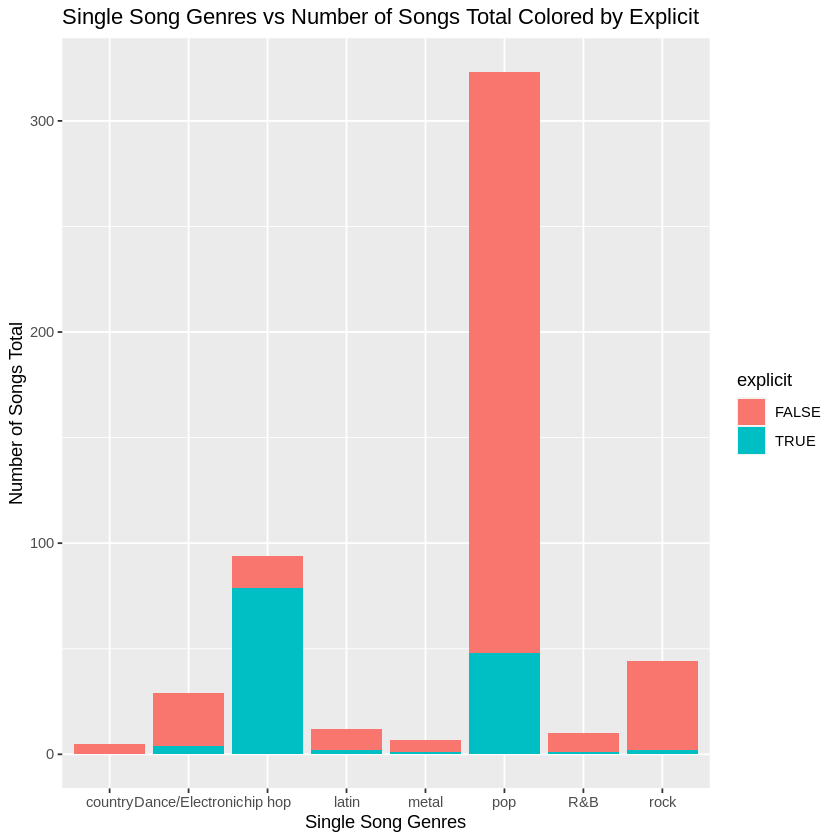

In [10]:
# Using training data: visualise data to find possible predictors relevant for analysis ----

# Bar: genre vs count (Number of Songs Total)
plot1 <- n_genre_table_training %>%
    ggplot(aes(x = genre, fill = explicit, y = n)) +
    geom_bar(stat = 'identity') +
    labs(x = "Single Song Genres", y = 'Number of Songs Total') +
    ggtitle('Single Song Genres vs Number of Songs Total Colored by Explicit')
plot1

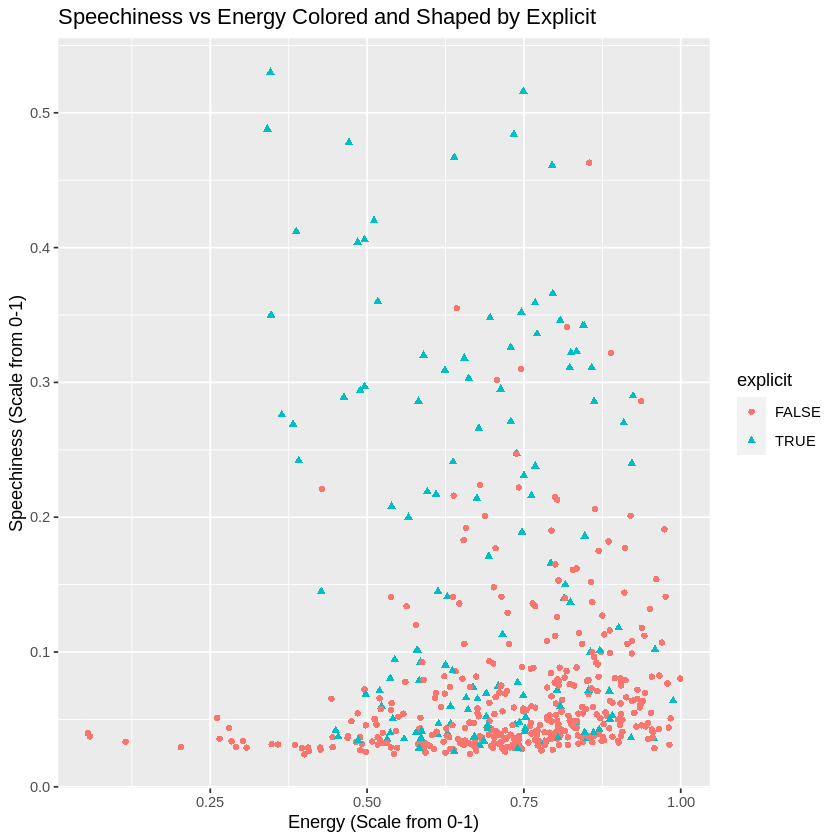

In [11]:
# Scatter: Speechiness vs Energy Colored and Shaped by Explicit
plot2 <- song_train %>%
    ggplot(aes(x = energy, y = speechiness, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Energy (Scale from 0-1)", y = 'Speechiness (Scale from 0-1)') +
    ggtitle('Speechiness vs Energy Colored and Shaped by Explicit')
plot2

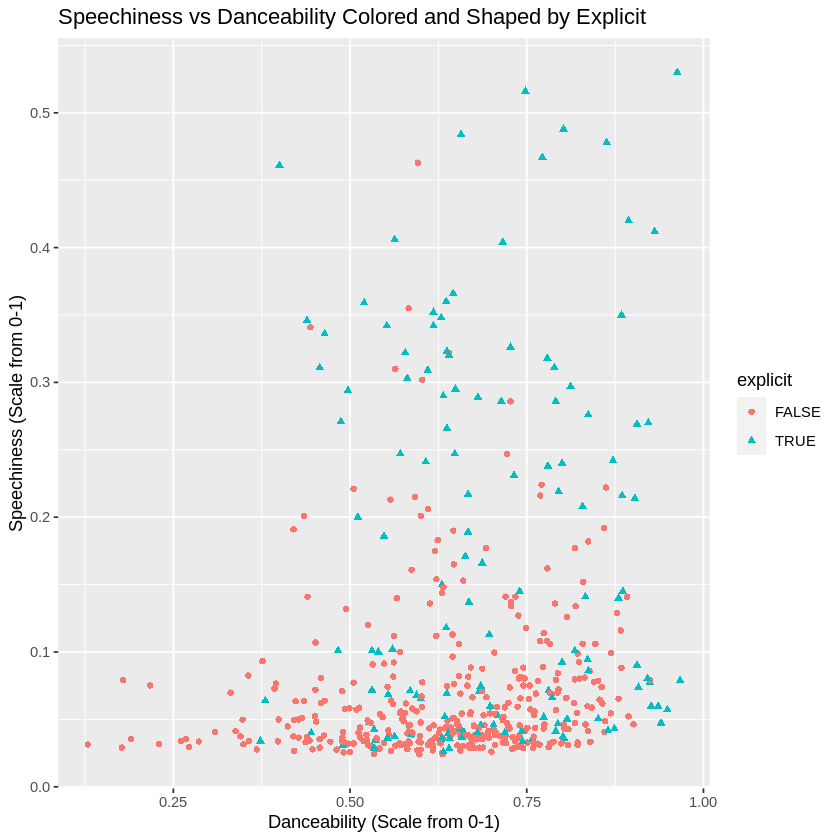

In [12]:
# Scatter: Speechiness vs Danceability Colored and Shaped by Explicit
plot3 <- song_train %>%
    ggplot(aes(x = danceability, y = speechiness, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Danceability (Scale from 0-1)", y = 'Speechiness (Scale from 0-1)') +
    ggtitle('Speechiness vs Danceability Colored and Shaped by Explicit')
plot3

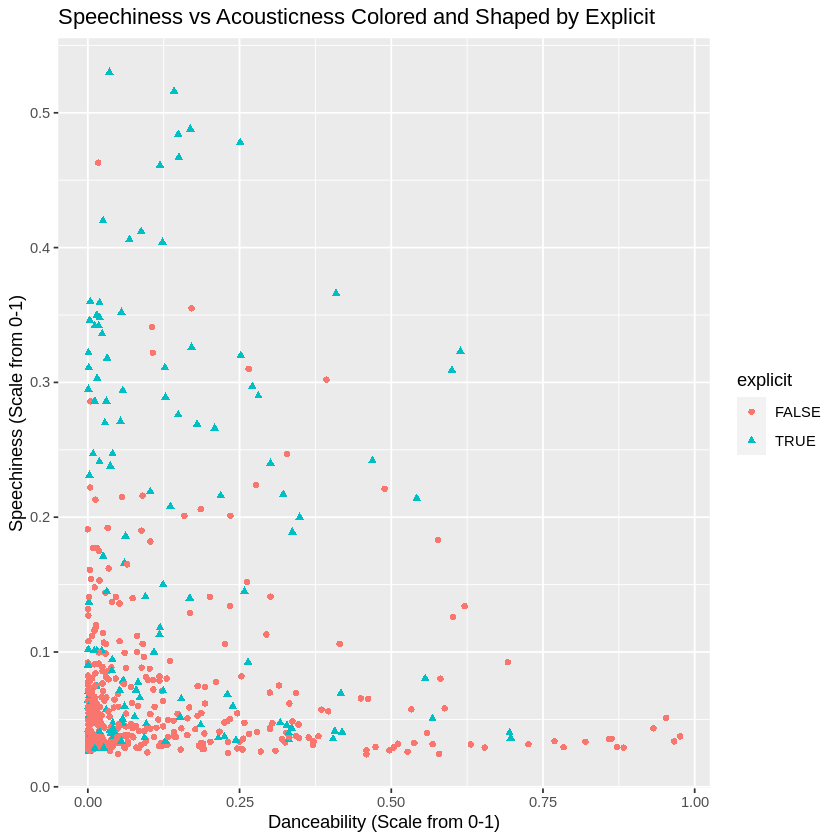

In [13]:
# Scatter : Speechiness vs Acousticness Colored and Shaped by Explicit
plot4 <- song_train %>%
    ggplot(aes(x = acousticness, y = speechiness, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Danceability (Scale from 0-1)", y = 'Speechiness (Scale from 0-1)') +
    ggtitle('Speechiness vs Acousticness Colored and Shaped by Explicit')
plot4

### Modeling

In [38]:
# Perform the data analysis -----------------------------------------------------------------------------------

# select only the columns that contains the response variable + predictors we will use
songs <- song %>%
    select(explicit, speechiness, danceability, energy) %>%
    mutate(explicit = as_factor(explicit))

# split data to Training + Testing data 
songs_split <- initial_split(songs, prop = 0.75, strata = explicit)
songs_train <- training(songs_split)
tracks_test <- testing(songs_split)

In [59]:
# balancing the data(since there are way too many unexplicit songs)

s_recipe <- recipe(explicit ~ speechiness + danceability + energy, data = songs_train) %>%
    step_upsample(explicit, over_ratio = 1, skip = FALSE) %>%
    prep()
upsampled_songs <- bake(s_recipe, songs_train)
songs_train <- upsampled_songs 
songs_train
upsampled_songs %>%
  group_by(explicit) %>%
  summarize(n = n())


speechiness,danceability,energy,explicit
<dbl>,<dbl>,<dbl>,<fct>
0.0437,0.751,0.834,FALSE
0.0516,0.614,0.928,FALSE
0.0379,0.720,0.808,FALSE
0.0292,0.617,0.728,FALSE
0.0287,0.745,0.958,FALSE
0.0989,0.822,0.922,FALSE
0.0552,0.671,0.880,FALSE
0.0369,0.740,0.876,FALSE
0.0460,0.425,0.852,FALSE


`summarise()` ungrouping output (override with `.groups` argument)


explicit,n
<fct>,<int>
FALSE,387
TRUE,387


In [39]:
# finding optimal K with balanced training data
songs_recipe <- recipe(explicit ~ ., data = songs_train ) %>%
    step_upsample(over_ratio = 1, skip = FALSE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 


In [40]:
songs_vfold <- vfold_cv(songs_train, v = 5, strata = explicit)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

knn_results <- workflow() %>%
    add_recipe(songs_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = songs_vfold, grid = k_vals) %>%
    collect_metrics()


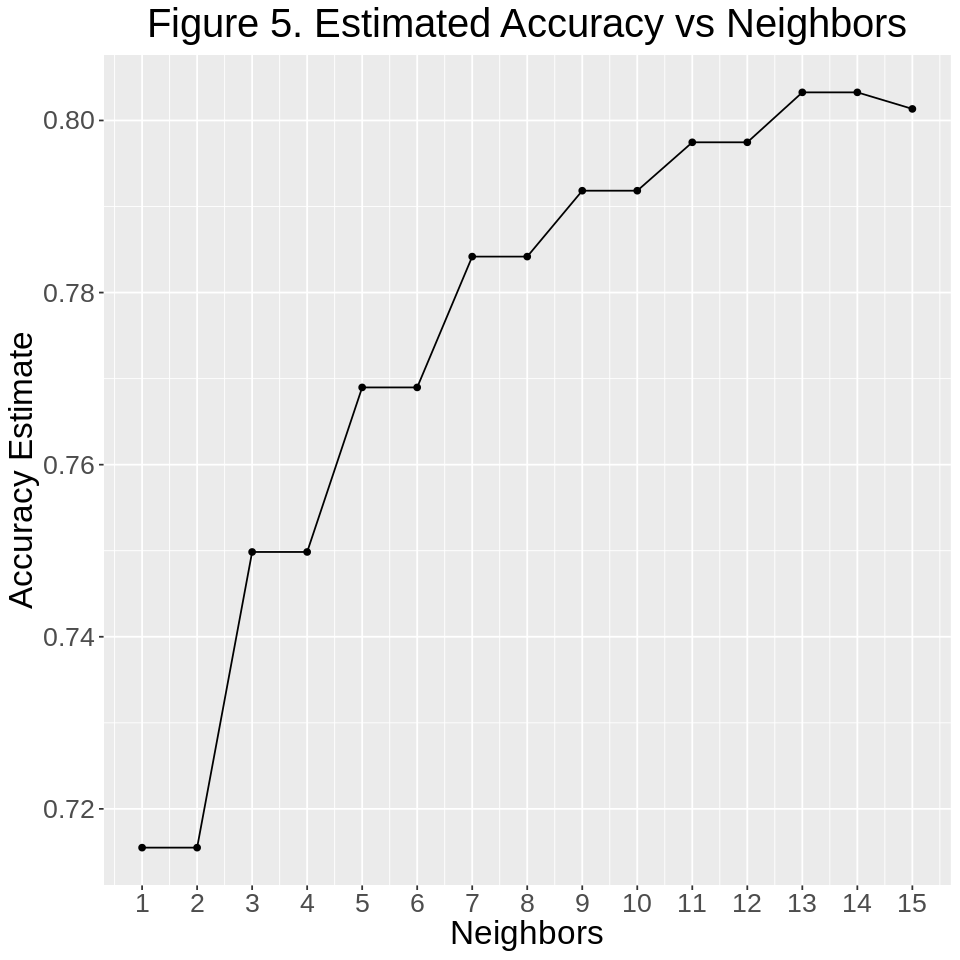

In [41]:
accuracies <- knn_results %>%
     filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(0, 30)) +
    ggtitle( "Figure 5. Estimated Accuracy vs Neighbors") +
    theme(plot.title = element_text(hjust = 0.5))

cross_val_plot

In [48]:
# build/train the model 
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
    set_engine("kknn") %>%
    set_mode("classification")

songs_fit <- workflow() %>%
             add_recipe(songs_recipe) %>%
             add_model(knn_spec_2) %>%
            fit(data = tracks_test)


# Results

In [52]:
# predict the model accuracy
songs_predictions <- predict(songs_fit, tracks_test) %>%
                        bind_cols(tracks_test)

accuracy_on_test <- songs_predictions %>% 
                        metrics(truth = explicit, estimate = .pred_class) %>%
                        filter(.metric == "accuracy")

print('Table 1: Statistics About The Quality of the Model')
accuracy_on_test


[1] "Table 1: Statistics About The Quality of the Model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8505747


In [53]:
# confusion matrix 
songs_conf_mat <- songs_predictions %>%
                        conf_mat(truth = explicit, estimate = .pred_class) 

print('Table2: Confusion Matrix of The Classifier')
songs_conf_mat


[1] "Table2: Confusion Matrix of The Classifier"


          Truth
Prediction FALSE TRUE
     FALSE   123   20
     TRUE      6   25

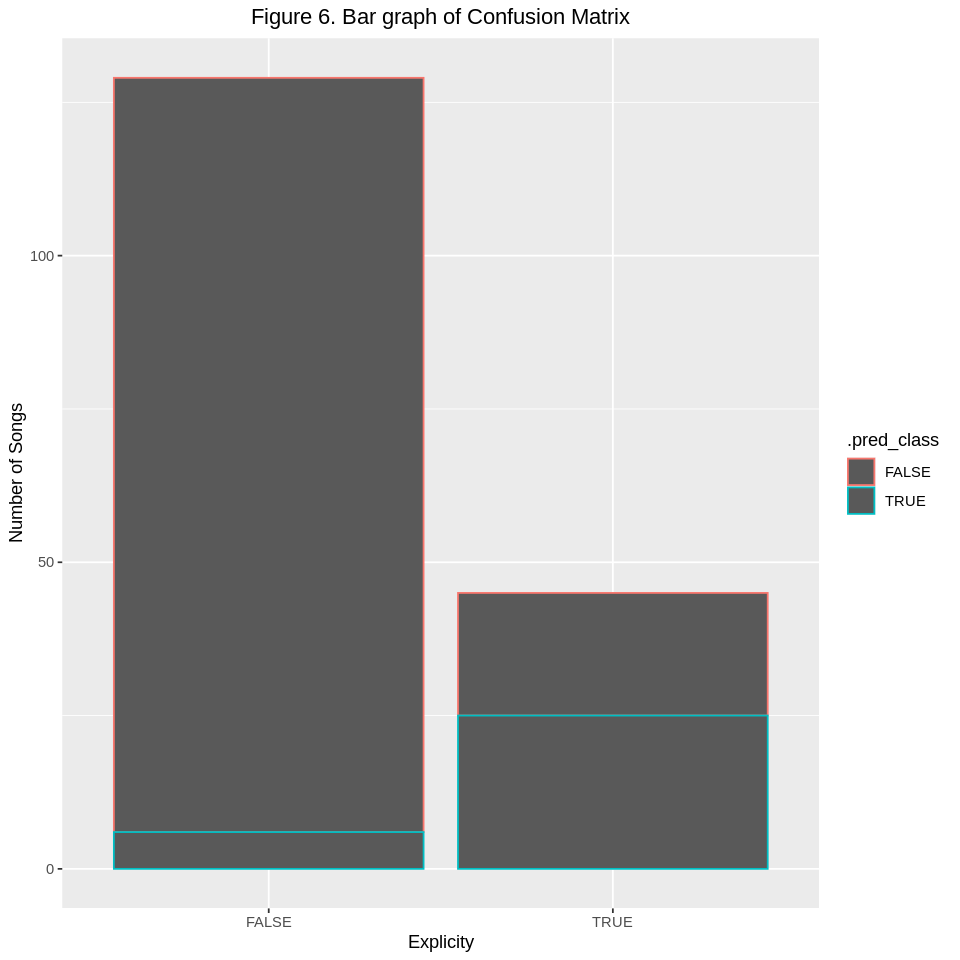

In [54]:
# visualization of the analysis ----------------------------------------------------------------------------

#bar graph of confusion matrix

mat_graph <- songs_predictions %>%
    group_by(explicit)%>%
    ggplot(aes(x = explicit,color = .pred_class))+geom_bar()+labs(x = "Explicity", y = 'Number of Songs') +
    ggtitle('Figure 6. Bar graph of Confusion Matrix') +
    theme(plot.title = element_text(hjust = 0.5))
mat_graph


In [57]:
# Table with best K, variables, accuracy
summary_of_analysis = matrix(c('Explicit', 'Speechiness, danceability, energy', 'K = 13', '85.05 %'), ncol = 1, byrow = TRUE) 

rownames(summary_of_analysis) <- c('Response variable', 'Predictors used', 'Optimal K', "Classifier's estimated accuracy on test data")
colnames(summary_of_analysis) <- c('Findings')

analysis <- as.data.frame(summary_of_analysis) 
analysis

,Findings
,<chr>
Response variable,Explicit
Predictors used,"Speechiness, danceability, energy"
Optimal K,K = 13
Classifier's estimated accuracy on test data,85.05 %


Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


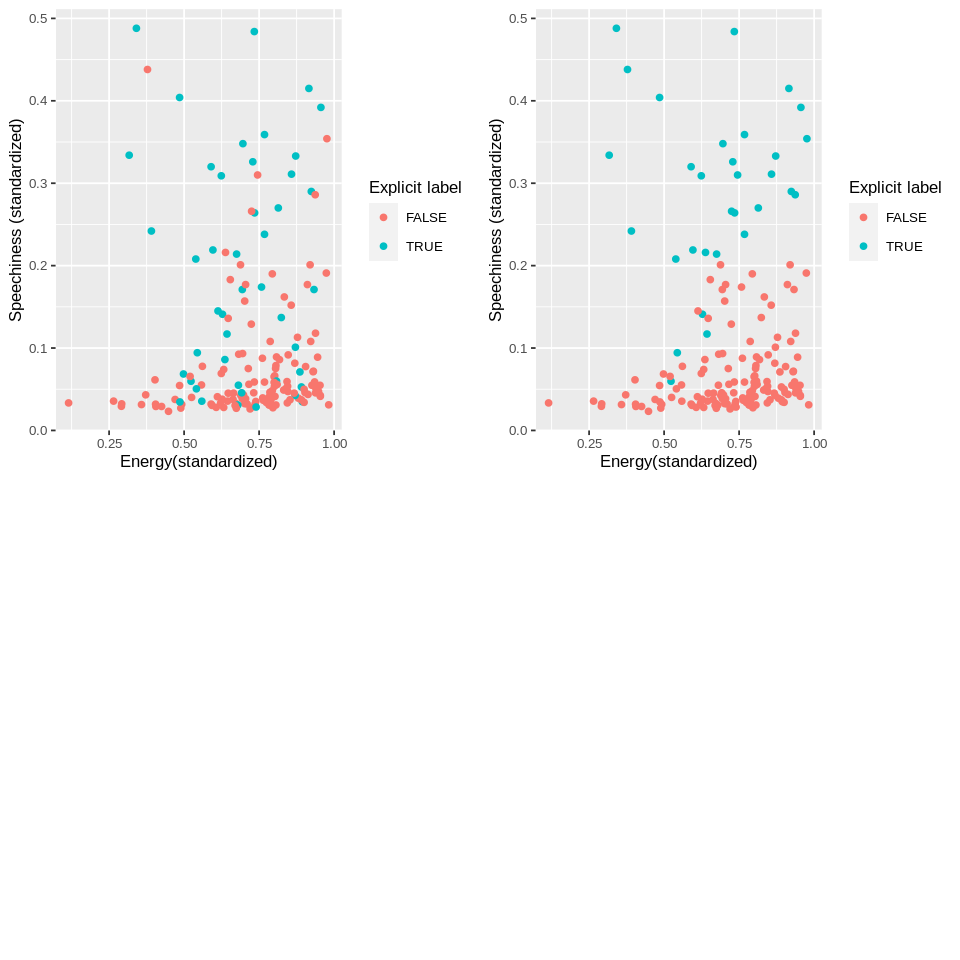

In [58]:
library(cowplot)

correct_plot <- ggplot(songs_predictions, aes(x = energy, y = speechiness, color = explicit)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

predict_plot <- ggplot(songs_predictions, aes(x = energy, y = speechiness, color = .pred_class)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

plot_grid(correct_plot,predict_plot, ncol = 2, NULL)



## *Work Cited*

(1) https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019

(2) https://community.spotify.com/t5/Content-Questions/Explicit-content/td-p/4625150

(3) https://datasciencebook.ca/
